# Vehicle Detection
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, your goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images

In [150]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
%matplotlib inline   

In [151]:
# Divide up into cars and notcars
cars = glob.glob('GTICollection/vehicles/*/*.png')
notcars = glob.glob('GTICollection/non-vehicles/*/*.png')
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
len(cars)

3425

In [152]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hist_feat=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        concat_feat = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            concat_feat.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            concat_feat.append(hist_features)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        concat_feat.append(hog_features)
        features.append(np.concatenate(concat_feat))
    # Return list of feature vectors
    return features

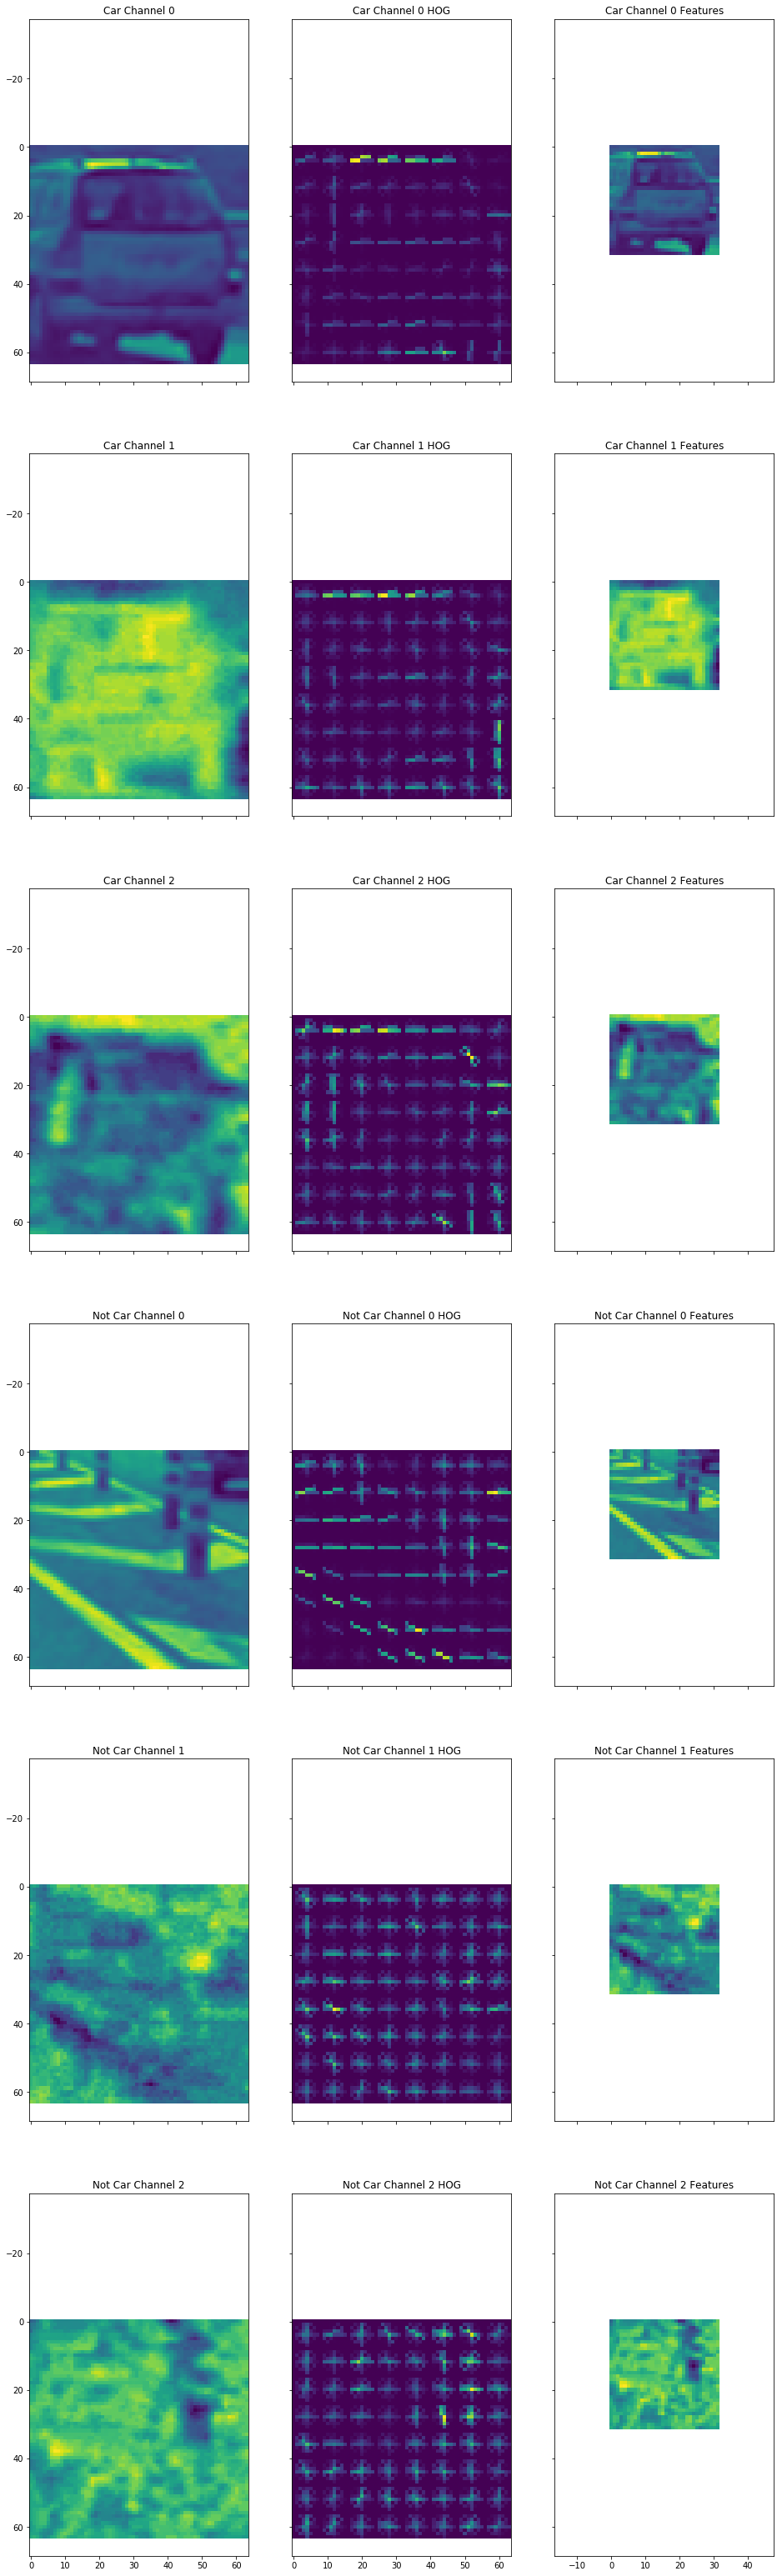

In [153]:
colorspace = "YUV" #'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" #0 # Can be 0, 1, 2, or "ALL"
hist_bins = 32
spatial_feat = True
hog_feat = True
hist_feat = True
spatial_size = (32, 32)

def display_channels_hog(car_image, notcar_image):
    size = (32, 32)
    f, axes = plt.subplots(6, 3, sharex='col', sharey='row', figsize=(16, 56))
    # ref: https://github.com/tatsuyah/vehicle-detection/blob/master/vehicle-detection.ipynb
    converted_car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)
    car_channels = [converted_car_image[:,:,i] for i in range(0, 3)]

    for i, (car_channel, axis) in enumerate(zip(car_channels, axes)):
        axis[0].imshow(car_channel)
        axis[0].set_title('Car Channel {}'.format(i))
        car_hog_feature, car_hog_image = get_hog_features(car_channel, 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
        car_channel_features = cv2.resize(car_channel, size)
        axis[1].imshow(car_hog_image)
        axis[1].set_title('Car Channel {} HOG'.format(i))
        axis[2].imshow(car_channel_features)
        axis[2].set_title('Car Channel {} Features'.format(i))
    
    converted_notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YUV)
    notcar_channels = [converted_notcar_image[:,:,i] for i in range(0, 3)]

    for i, (notcar_channel, axis) in enumerate(zip(notcar_channels, axes[3:])):
        axis[0].imshow(notcar_channel)
        axis[0].set_title('Not Car Channel {}'.format(i))
        notcar_hog_feature, notcar_hog_image = get_hog_features(notcar_channel, 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
        notcar_channel_features = cv2.resize(notcar_channel, size)
        axis[1].imshow(notcar_hog_image)
        axis[1].set_title('Not Car Channel {} HOG'.format(i))
        axis[2].imshow(notcar_channel_features)
        axis[2].set_title('Not Car Channel {} Features'.format(i))
        
    plt.show()
display_channels_hog(mpimg.imread(cars[0]), mpimg.imread(notcars[0]))

In [154]:
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat)

* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

In [155]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9048


## Train a classifier Linear SVM classifier

In [156]:
from sklearn.model_selection import GridSearchCV
# Use a linear SVC 
#svc = LinearSVC()
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#svr = SVC()
svc = LinearSVC(C=2.0) 
#svc = GridSearchCV(svr, parameters)
# Check the training time for the SVC
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

Test Accuracy of SVC =  0.9843
My SVC predicts:  [ 1.  1.  0.  0.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  0.  0.  1.  0.  1.]


* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

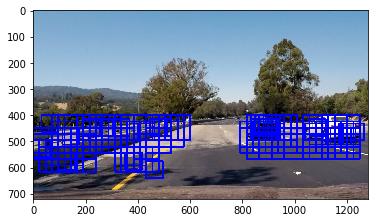

In [157]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
def find_cars_aux(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')#conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = [(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)]
                cv2.rectangle(draw_img,bbox[0], bbox[1],(0,0,255),6) 
                bboxes.append(bbox)
    return draw_img, bboxes
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    out_img = img
    scale = 1.0
    bbxs = []
    for step in range(2):
        out_img, bboxes = find_cars_aux(out_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        scale += 0.5
        bbxs.extend(bboxes)
    return out_img, bbxs
    
ystart = 400
ystop = 656
scale = 1.5
    
img = mpimg.imread('./test_images/test4.jpg')
out_img, bboxes = find_cars(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

Reading ./test_images/test1.jpg
Reading ./test_images/test2.jpg
Reading ./test_images/test3.jpg
Reading ./test_images/test4.jpg


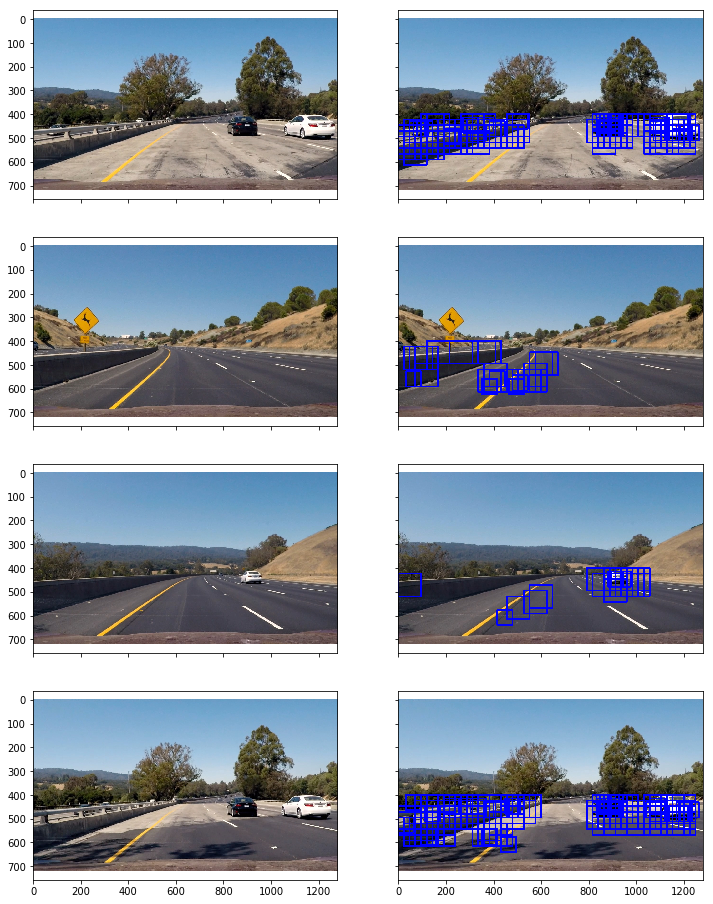

In [158]:
n = 10
def test_bbox_images(n):
    out_imgs = []
    bbxs = []
    ystart = 400
    ystop = 656
    scale = 1.5
    hist_bins = 32
    f, axes = plt.subplots(4, 2, sharex='col', sharey='row', figsize=(12, 16))

    for i, axis in enumerate(axes):
        fname = './test_images/test{}.jpg'.format(i+1)
        print('Reading ' + fname)
        image = mpimg.imread(fname)
        out_img, bboxes = find_cars(image, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        out_imgs.append(out_img)
        bbxs.append(bboxes)
        axis[0].imshow(image)
        axis[1].imshow(out_img)
        
    plt.show()
    return out_imgs, bbxs
out_imgs, bbxs = test_bbox_images(n)

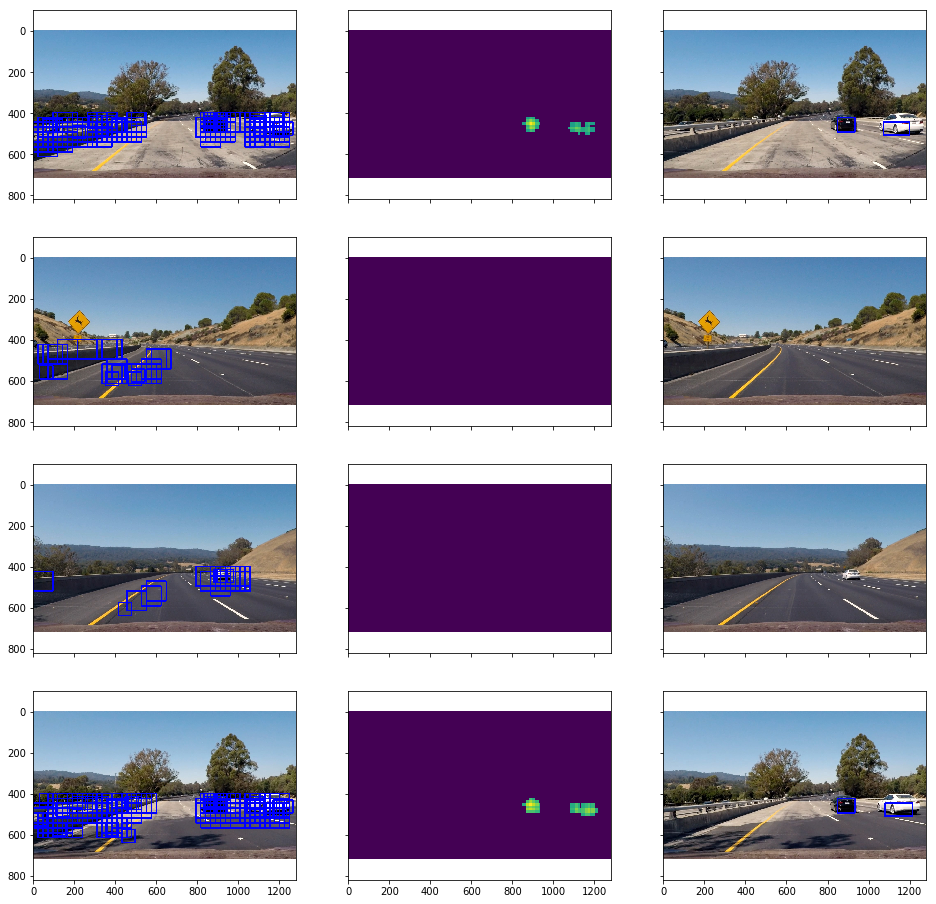

In [164]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def make_heat_img(image, box_list):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return heatmap, draw_img

def get_heatmap(image, bboxes):
    threshold = 12
    heat = np.zeros_like(image[:,:,0]).astype(np.float) 
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    return heatmap

def test_heat_images(drawn_imgs, bboxes):
    heats = []
    f, axes = plt.subplots(len(drawn_imgs), 3, sharex='col', sharey='row', figsize=(16, 16))
    for i, (img, axis) in enumerate(zip(drawn_imgs, axes)):
        fname = './test_images/test{}.jpg'.format(i+1)
        image = mpimg.imread(fname)
        #heat_img, new_boxes = make_heat_img(img, bboxes[i]) 
        heat_img = get_heatmap(img, bboxes[i])
        heats.append(heat_img)
        axis[0].imshow(img)
        axis[1].imshow(heat_img)
        labels = label(heat_img)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        axis[2].imshow(draw_img)
        
    plt.show()
    return heats
heats = test_heat_images(out_imgs, bbxs)

* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

* Estimate a bounding box for vehicles detected.

In [171]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

heatmaps = []
def detect_cars(img):
    global heatmaps
    out_img, bboxes = find_cars(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat_img = get_heatmap(out_img, bboxes)
    
    heatmaps.append(heat_img)
    
    heatmap = np.zeros_like(heat_img).astype(np.float)
    for heat in heatmaps:
        heatmap = heatmap + heat
    heatmap = heatmap / len(heatmaps)
    if len(heatmaps) > 5:    
        heatmaps = heatmaps[1:]
        
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

#history = deque(maxlen = 8)
output = 'test_result.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4



 97%|█████████▋| 38/39 [00:59<00:01,  1.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

CPU times: user 57.3 s, sys: 2.42 s, total: 59.7 s
Wall time: 1min


In [166]:
output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [37:36<00:01,  1.64s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 34min 21s, sys: 1min 30s, total: 35min 51s
Wall time: 37min 37s
